# Spam Email Classifier using Bidirectional LSTM

### Load dependencies

In [ ]:
import pandas as pd
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import io
import pickle

ModuleNotFoundError: No module named 'keras.preprocessing.text'

In [ ]:
print(tf.__version__)

2.15.0


### Load dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving enron_spam_data.csv to enron_spam_data.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['enron_spam_data.csv']))

In [ ]:
df.head()

,Message ID,Subject,Message,Spam/Ham,Date
0,0,christmas tree farm pictures,NaN,ham,1999-12-10
1,1,"vastar resources , inc .","gary , production from the high island larger ...",ham,1999-12-13
2,2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc,ham,1999-12-14
3,3,re : issue,fyi - see note below - already done .\nstella\...,ham,1999-12-14
4,4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...,ham,1999-12-14


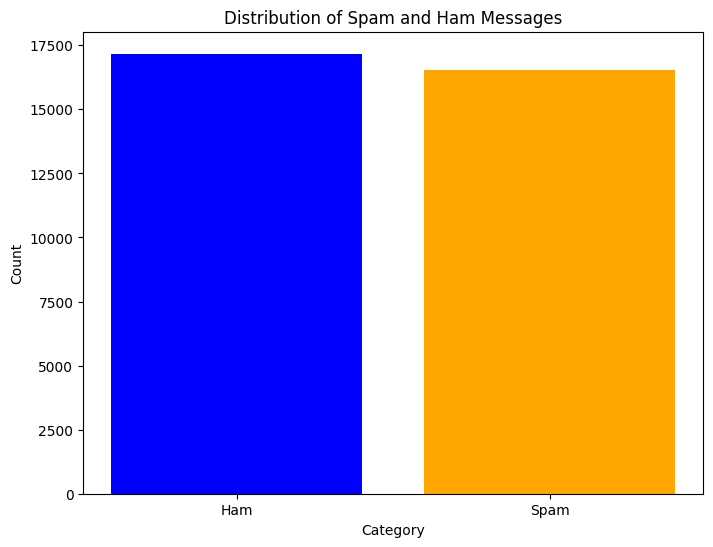

In [ ]:
# Plot the distribution of Spam and Ham messages
spam_count = df['Spam/Ham'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(spam_count.index, spam_count.values, color=['blue', 'orange'])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Distribution of Spam and Ham Messages')
plt.xticks(ticks=spam_count.index, labels=['Ham', 'Spam'], rotation=0)
plt.show()

###  Preprocess data

In [ ]:
na_subject_count = df['Subject'].isna().sum()
na_message_count = df['Message'].isna().sum()

print(f"Number of missing values in 'Subject': {na_subject_count}")
print(f"Number of missing values in 'Message': {na_message_count}")

Number of missing values in 'Subject': 289
Number of missing values in 'Message': 371


In [ ]:
# Drop missing values
df.dropna(subset=['Subject', 'Message'], inplace=True)#

In [ ]:
# Convert non-string values to empty strings and process text
df['Subject'] = df['Subject'].astype(str)
df['Message'] = df['Message'].astype(str)

In [ ]:
# Combine Subject and Message into one text
df['Combine_Message'] = df['Subject'] + ' ' + df['Message']
df['Processed_Message'] = df['Combine_Message'].str.lower()

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Spam/Ham'])
y = y.reshape(-1, 1)
y.shape

(33107, 1)

### Split the dataset

In [ ]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Processed_Message'], y, test_size=0.2, random_state=42)

### Tokenize

In [ ]:
# Tokenize the training data
max_vocab_size = 30000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_train)

In [ ]:
# Pad training and val data
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)

##### Check the length of sequences to set the proper maximum sequence of length

In [ ]:
# Compute lengths of sequences
lengths = [len(seq) for seq in sequences_train]

# Create a DataFrame for plotting
lengths_df = pd.DataFrame(lengths, columns=['Length'])

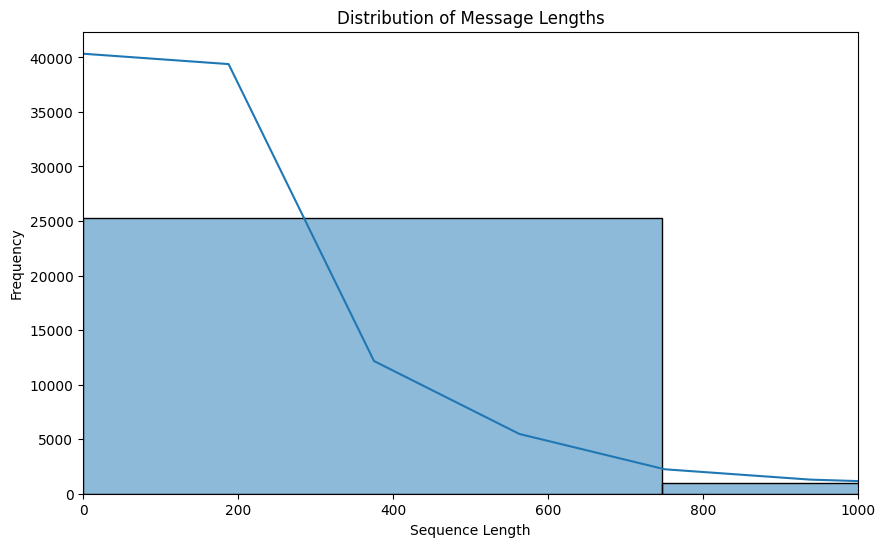

In [ ]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(lengths_df['Length'], bins=50, kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.show()

In [ ]:
# Define max sequence length
max_sequence_length = 300

In [ ]:
# Pad sequences
padded_sequences_train = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')
padded_sequences_val = pad_sequences(sequences_val, maxlen=max_sequence_length, padding='post')

In [ ]:
# Check the length of the padded sequences
for i in range(5):
  print(len(padded_sequences_train[i]))

300
300
300
300
300


In [ ]:
def sequence_to_text(sequence, tokenizer):
    reverse_word_index = {index: word for word, index in tokenizer.word_index.items()}
    return ' '.join([reverse_word_index.get(i, '?') for i in sequence if i != 0])

In [ ]:
sequence = padded_sequences_train[5]

# Convert the sequence back to text
text = sequence_to_text(sequence, tokenizer)
text

'learn how to get this freedom freedom of choice prescriptions for female sexual it \x92 s such a part of me i assume everyone can see it necessity makes even the brave history is a nightmare from which i am trying to awake'

### Design neural network architecture

In [ ]:
model = Sequential()

# Embedding Layer
model.add(Embedding(input_dim=max_vocab_size, output_dim=100, input_length=max_sequence_length))
model.add(SpatialDropout1D(0.2))

# LSTM Layer
model.add(Bidirectional(LSTM(128, dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(64, dropout=0.2)))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          3000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 300, 100)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 300, 256)          234496    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                        

### Compile model

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

### Train model

In [ ]:
model.fit(padded_sequences_train, y_train, epochs=5, batch_size=64, validation_data=(padded_sequences_val, y_val))

Epoch 1/5
414/414 [==============================] - 1212s 3s/step - loss: 0.1458 - accuracy: 0.9414 - val_loss: 0.0760 - val_accuracy: 0.9767
Epoch 2/5
414/414 [==============================] - 1150s 3s/step - loss: 0.0554 - accuracy: 0.9829 - val_loss: 0.0553 - val_accuracy: 0.9864
Epoch 3/5
414/414 [==============================] - 1139s 3s/step - loss: 0.0253 - accuracy: 0.9923 - val_loss: 0.1829 - val_accuracy: 0.9456
Epoch 4/5
 39/414 [=>............................] - ETA: 16:09 - loss: 0.0698 - accuracy: 0.9780

### Evaluate model

In [ ]:
# Evaluate the model
accuracy = model.evaluate(padded_sequences_val, y_val)[1]
print(f"Test Accuracy: {accuracy * 100:.2f}%")

y_pred_prob = model.predict(padded_sequences_val).flatten()
roc_auc = roc_auc_score(y_val, y_pred_prob)
print(f"ROC AUC: {roc_auc:.2f}")

207/207 [==============================] - 4s 20ms/step - loss: 0.0432 - accuracy: 0.9900
Test Accuracy: 99.00%
207/207 [==============================] - 4s 15ms/step
ROC AUC: 1.00


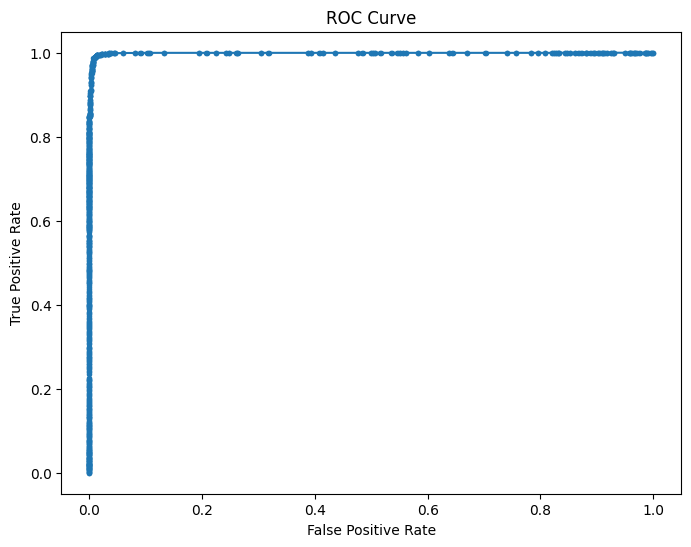

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_val, y_pred_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

207/207 [==============================] - 3s 16ms/step


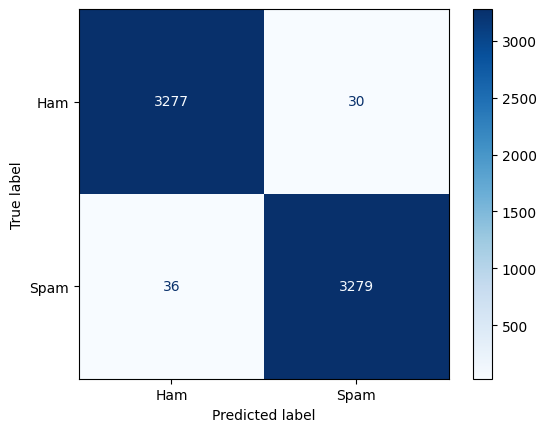

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = (model.predict(padded_sequences_val) > 0.5).astype("int32")
cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

### Save the model and tokenizer

In [ ]:
# Save the model
model.save('spam_detection_model.h5')

# Save the tokenizer
with open('tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_path = '/content/drive/My Drive/spam_detection_model.h5'
tokenizer_path = '/content/drive/My Drive/tokenizer.pkl'

model.save(model_path)
with open(tokenizer_path, 'wb') as file:
    pickle.dump(tokenizer, file)

### Perform inference

In [ ]:
# Function to preprocess new text
def preprocess_text(text):
    text = text.lower()
    return text

# Function to predict if a text is spam
def predict_spam(text):
    preprocessed_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([preprocessed_text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
    prediction = model.predict(padded_sequence)
    return prediction[0][0] * 100

# Example usage
spam_text = "You’ve been pre-approved for a $10,000 loan with low interest rates. Click here to apply now. Get your funds in as little as 24 hours!"
ham_text = "I’m writing to update you on the sales report. I’ve completed the preliminary analysis and attached the draft for your review. Please let me know if you need any changes."

spam_probability_spam = predict_spam(spam_text)
spam_probability_ham = predict_spam(ham_text)

print(f"Spam Probability: {spam_probability_spam:.2f}%")
print(f"Spam Probability: {spam_probability_ham:.2f}%")

1/1 [==============================] - 0s 90ms/step
Spam Probability: 99.99%
Spam Probability: 0.03%
